# SFINCS Model setup

We want to combine data from the SRTM of resolution 30 m with data by Lin et al. for the river widths.

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

import hydromt
from hydromt.config import configread
from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr

logger = setuplog("prepare data catalog", log_level=10)

2024-03-07 11:12:28,935 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


**Steps followed in this notebook to build your SFINCS model:**
<ol> 
<li> Open SfincsModel class, set data library and output folder </li>
<li> Specify characteristics of the wanted grid </li>
<li> Load in wanted elevation datasets </li>
<li> Make mask of active and inactive cells </li>
<li> Update mask with water level and outflow boundary cells</li>
<li> Add spatially varying roughness data</li>
<li> Make subgrid derived tables</li>
<li> Add spatially varying infiltration data</li>
<li> Add water level time-series as forcing</li>
<li> Add an upstream discharge time-series as forcing</li>
<li> Add spatially varying rainfall data</li>
<li> Add weirfile</li>
<li> Add observation points</li>
<li> Add observation lines</li>
<li> Show model</li>
<li> Save all files</li>
</ol> 

### 1. Initialize SfincsModel class, set data library and output folder:

In [2]:
model_root = Path(r"model")
data_libs = [
    Path(r"data/1_static/data_static.yml"),
    #Path(r"data/2_forcing/data_forcing.yml"),
]
base_root = Path(r"model/base")

### 2. Specify characteristics of the wanted grid and generate grid:

In [3]:
# bbox = [36.6209722222222140, -3.1540277777777708,
#          41.5604166666666472, 0.4798611111111084]
# region = {"bbox": bbox}
model = SfincsModel(root=base_root, data_libs=data_libs, logger=logger)


2024-03-06 17:02:53,057 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static.yml
2024-03-06 17:02:53,066 - prepare data catalog - log - DEBUG - Appending log messages to file c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\base\hydromt.log.
2024-03-06 17:02:53,067 - prepare data catalog - model_api - INFO - Initializing sfincs model from hydromt_sfincs (v1.0.3).


In [4]:
# model.setup_grid_from_region(
#     region=region,
#     res=0.01,
#     crs=4326,
#     hydrography_fn="srtm30"
#     )

print(model.config)

2024-03-06 17:02:53,090 - prepare data catalog - basin_mask - DEBUG - Parsed region (kind=bbox): {'bbox': [36.620972222222214, -3.1540277777777708, 41.56041666666665, 0.4798611111111084]}
{'mmax': 457, 'nmax': 348, 'dx': 0.01, 'dy': 0.01, 'x0': 37.0, 'y0': -3.0, 'rotation': 0, 'latitude': 0.0, 'tref': datetime.datetime(2010, 2, 1, 0, 0), 'tstart': datetime.datetime(2010, 2, 1, 0, 0), 'tstop': datetime.datetime(2010, 2, 2, 0, 0), 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 1, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015

### 3. Load in wanted elevation datasets:

2024-03-06 17:02:53,133 - prepare data catalog - rasterdataset - INFO - Reading srtm30 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\STRM30DEM.tif
2024-03-06 17:02:53,224 - prepare data catalog - rasterdataset - DEBUG - Clip to [37.000, -3.000, 41.570, 0.480] (epsg:4326))


2024-03-06 17:02:54,422 - prepare data catalog - merge - DEBUG - Reprojection method of first dataset is: average
2024-03-06 17:02:54,430 - prepare data catalog - sfincs - WARNING - Interpolate elevation at 58696 cells
Plotting


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


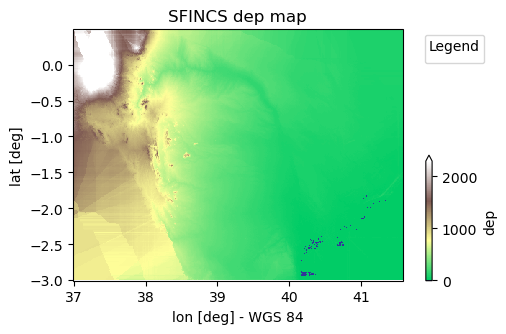

In [5]:
datasets_dep = [{"elevtn": "srtm30"}]
dep = model.setup_dep(datasets_dep = datasets_dep)

print("Plotting")
_ = model.plot_basemap(variable="dep")

### 4. Make mask of active and inactive cells:


2024-03-06 17:15:36,060 - prepare data catalog - geodataframe - INFO - Reading osm_coastlines vector data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\osm_coastlines\osm_coastlines.gpkg
2024-03-06 17:15:36,181 - prepare data catalog - geodataframe - DEBUG - Clip intersects [40.160, -3.000, 41.570, -1.660] (EPSG:4326)
2024-03-06 17:15:36,262 - prepare data catalog - regulargrid - INFO - 8 gaps outside valid elevation range < 10.0 km2.
2024-03-06 17:15:36,266 - prepare data catalog - sfincs - INFO - Derive region geometry based on active cells.
2024-03-06 17:15:36,279 - prepare data catalog - model_api - WARNING - Replacing geom: region


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


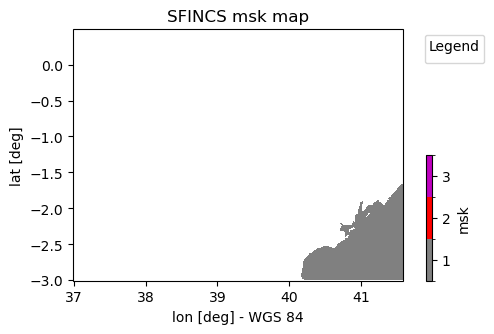

In [23]:
# TODO
model.setup_mask_active("osm_coastlines", reset_mask=True)
_ = model.plot_basemap(variable="msk", plot_bounds=True)

### 5. Update mask with water level and outflow boundary cells - including use of polygons:

2024-03-06 17:10:52,574 - prepare data catalog - geodataframe - INFO - Reading osm_coastlines vector data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\osm_coastlines\osm_coastlines.gpkg


2024-03-06 17:10:52,781 - prepare data catalog - geodataframe - DEBUG - Clip intersects [37.000, -3.000, 41.570, 0.480] (EPSG:4326)


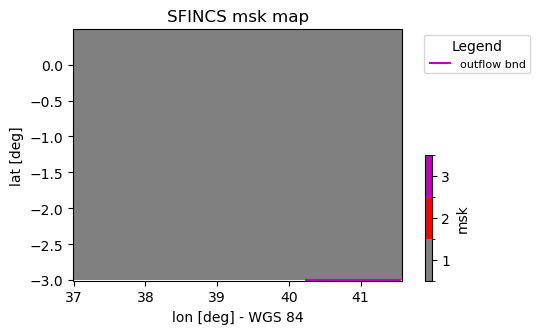

In [16]:
# Choosing how to choose you active cells can be based on multiple criteria, here we only specify a minimum elevation of -5 meters
model.setup_mask_bounds(btype="outflow", include_mask ="osm_coastlines")

# Make a plot of the mask file
_ = model.plot_basemap(variable="msk", plot_bounds=True)

### 6. Add river inflow points:

In [ ]:
# derive river from hydrography data based on a minimum river length (river_len)
# and minimum upstream area (river_upa)

model.setup_river_inflow(
    hydrography="merit_hydro", river_len=1000, river_upa=50, keep_rivers_geom=True
)

# Make a plot of model
# note the src points and derived river network
fig, ax = model.plot_basemap(variable="dep", plot_bounds=False)